# **Library & Depedencies**


In [36]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import MarianMTModel, MarianTokenizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from rich import print
from rich.table import Table
from rich.console import Console
import shutil
import torch
import sacremoses
import sentencepiece
from tqdm.auto import tqdm
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

# **Preprocessing**

<li>Stop Words Removal</li>
<li>Case Folding</li>


In [ ]:
df = pd.read_csv("translated_data.csv")
tiket_df = pd.DataFrame(df)
tqdm.pandas()
stop_words = set(stopwords.words("english"))
punctuation = set(string.punctuation)

In [ ]:
def clean_text(text):
    if not isinstance(text, str):
        return print(f"Not cleaned: {""}")
    tokens = word_tokenize(text.lower())
    cleaned_tokens = [
        word for word in tokens if word not in stop_words and word not in punctuation
    ]
    return " ".join(cleaned_tokens)


tiket_df["cleaned_text"] = tiket_df["translated_body"].progress_apply(clean_text)
display(tiket_df[["cleaned_text", "translated_body"]].head(15))

# **BERT CLS Tokenization**


In [35]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokenized_output = tokenizer(
    list(tiket_df["cleaned_text"].astype(str).tolist()),
    padding=True,
    truncation=True,
    return_tensors="pt",
)

tiket_df["tokenized_body"] = tokenized_output["input_ids"].tolist()
display(tiket_df[["tokenized_body", "cleaned_text"]].head(5))
tiket_df.to_csv("translated_data.csv", index=False)

KeyboardInterrupt: 

# **Split Data**

Data akan dibagi jadi 80:10:10 (dasarnya apa masih cari lupa nemu di mana). `type`, `queue ` dan `prioritas` masing-masing di-split 80:10:10.


C:\Users\prith\AppData\Local\Temp\ipykernel_22832\498759016.py:5: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  a = sns.countplot(


Text(0, 0.5, 'Count')

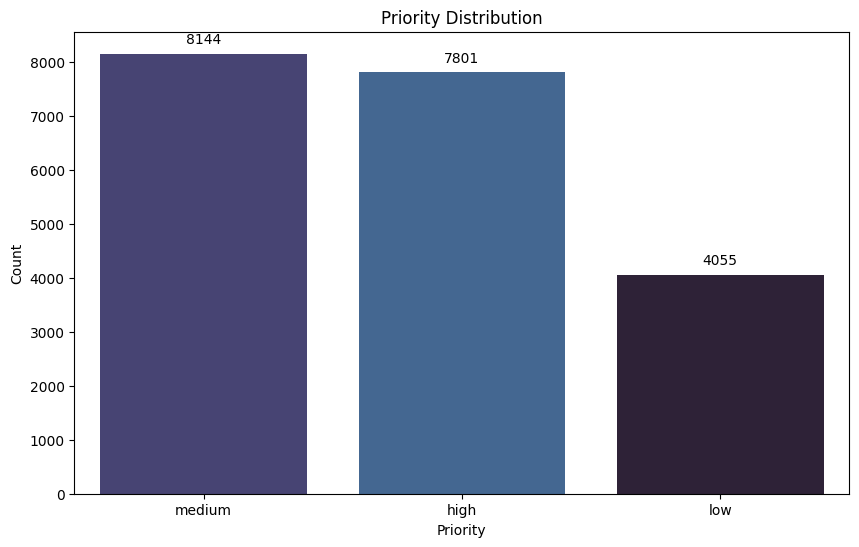

In [ ]:
priority = pd.DataFrame(tiket_df["priority"])
priority_order = df["priority"].value_counts().index

plt.figure(figsize=(10, 6))
a = sns.countplot(
    data=df,
    x="priority",
    hue="priority",
    order=priority_order,
    palette=sns.color_palette("mako"),
)
for container in a.containers:
    a.bar_label(container, fmt="%d", label_type="edge", padding=5)
plt.title("Priority Distribution")
plt.xlabel("Priority")
plt.ylabel("Count")

tiket_df["priority_label"] = tiket_df["priority"].map(priority)
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(
    model_name, num_labels=len(priority_mapping)
)
model.eval()

sentence = tiket_df["cleaned_text"][0]

inputs = tokenizer.encode_plus(sentence, return_tensors="pt", add_special_tokens=True)
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]


def predict(ids, masks):
    with torch.no_grad():
        outputs = model(ids, attention_mask=masks)
        logits = outputs.logits
        # Kembalikan logit
        return logits.numpy()


# Tokenisasi ulang untuk SHAP Explainer
# SHAP DeepExplainer membutuhkan token ids numerik sebagai input
explainer = shap.Explainer(
    predict,
    input_ids=input_ids,
    feature_names=tokenizer.convert_ids_to_tokens(input_ids[0]),
    masker=tokenizer.mask_token_id,
)
# Generate SHAP values
shap_values = explainer(input_ids, attention_mask=attention_mask)

# Visualisasi SHAP
# Plot ini menunjukkan kontribusi setiap kata terhadap prediksi
shap.plots.text(shap_values)

In [ ]:
queue = tiket_df["queue"]
queue_target = tiket_df["queue"].value_counts()
print(queue_target)

queue_classes = len(np.unique(queue))
print(queue_classes)

weight_zero = len(queue) / (2 * queue_target[0])
weight_one = len(queue) / (2 * queue_target[1])
print(weight_one)
print(weight_zero)

queue
Technical Support                  5824
Product Support                    3708
Customer Service                   3152
IT Support                         2292
Billing and Payments               2086
Returns and Exchanges              1001
Service Outages and Maintenance     764
Sales and Pre-Sales                 572
Human Resources                     338
General Inquiry                     263
Name: count, dtype: int64

10

C:\Users\prith\AppData\Local\Temp\ipykernel_22832\3743316488.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  weight_zero = len(queue) / (2 * queue_target[0])
C:\Users\prith\AppData\Local\Temp\ipykernel_22832\3743316488.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  weight_one = len(queue) / (2 * queue_target[1])


2.696871628910464

1.717032967032967